<a href="https://colab.research.google.com/github/arqavan94/Persian_NLP_Task/blob/main/postagger_Ezafetag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, SimpleRNN,GRU,Dropout,Conv1D, MaxPooling1D
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pickle as pkl
from keras import metrics
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import random

# **Prepare Data**

In [ ]:
text_labels= np.load('/content/drive/MyDrive/text_labels.npz', allow_pickle=True)
text_labels.files
text_labels= text_labels['arr_0']

**Split Ezafe-tag**

In [ ]:
words, tags = set(), set()
for sent in text_labels:
    for word, tag in sent:
      if tag in ('ADVe','AJe','CONJe','DETe','NUMe','Ne','PROe','Pe','RESe'):
          words.add(word)
          tags.add(tag)         

# **Convert to number**

In [ ]:
word2idx = {w: i + 2 for i, w in enumerate(list(words))}
word2idx['PAD'] = 0
word2idx['UNK'] = 1
tag2idx = {t: i+1 for i, t in enumerate(list(tags))}
idx2word = {i + 2: w for i, w in enumerate(list(words))}
idx2tag = {i+1: t for i, t in enumerate(list(tags))}
tag2idx['<PAD>'] = 0

In [ ]:
X=[]
y =[]
for sent in text_labels:
  word2idxlist , tag2idxlist =[],[]
  flag= False
  for w,t in sent:
    if t in ('ADVe','AJe','CONJe','DETe','NUMe','Ne','PROe','Pe','RESe'):
      word2idxlist.append(word2idx[w])
      tag2idxlist.append(tag2idx[t])
      flag=True
  if flag:
    X.append(word2idxlist)
    y.append(tag2idxlist)

In [ ]:
lengths=[len(seq) for seq in X]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 219


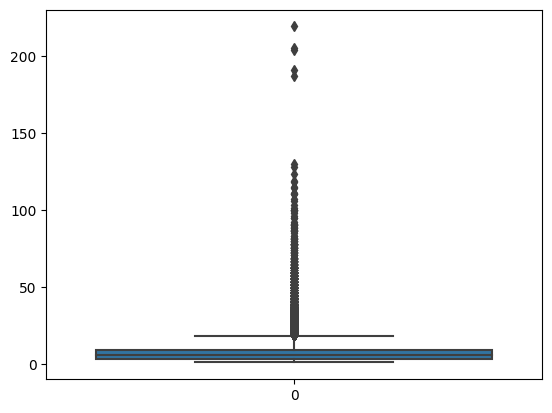

In [ ]:
sns.boxplot(lengths)
plt.show()

# **Pad sequences**

In [ ]:
max_len = 120
X = pad_sequences(X, maxlen=max_len, padding='post')
y = pad_sequences(y, maxlen=max_len, padding='post')

# **Convert to categorical (one_hot)**

In [ ]:
Y_cat = tf.keras.utils.to_categorical(y)

# **Split data to train, test, validation**

In [ ]:
# split train , test
(X_train, X_test, y_train, y_test) = train_test_split(X, Y_cat, test_size=0.2, random_state=42)

#split train in to train , vlaidation
(X_train, X_validation, y_train, y_validation) = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

**Save data as pickle**

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/X_train_e.pkl", "wb") as f:
    pkl.dump(X_train,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/X_test_e.pkl", "wb") as f:
    pkl.dump(X_test,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/y_train_e.pkl", "wb") as f:
    pkl.dump(y_train,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/y_test_e.pkl", "wb") as f:
    pkl.dump(y_test,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/y_validation_e.pkl", "wb") as f:
    pkl.dump(y_validation,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/X_validation_e.pkl", "wb") as f:
    pkl.dump(X_validation,f)

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/words.pkl", "wb") as f:
    pkl.dump(words,f)

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/tags.pkl", "wb") as f:
    pkl.dump(tags,f)

In [ ]:
set(tags)

{'ADVe', 'AJe', 'CONJe', 'DETe', 'NUMe', 'Ne', 'PROe', 'Pe', 'RESe'}

# **Load Data**

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/X_train_e.pkl", "rb") as f:
    X_train= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/X_test_e.pkl", "rb") as f:
    X_test= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/y_train_e.pkl", "rb") as f:
    y_train= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/y_test_e.pkl", "rb") as f:
    y_test= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/X_validation_e.pkl", "rb") as f:
    X_validation= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/y_validation_e.pkl", "rb") as f:
    y_validation= pkl.load(f)

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/words.pkl", "rb") as f:
    words= pkl.load(f)

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data/tags.pkl", "rb") as f:
    tags= pkl.load(f)

In [ ]:
embedding_size= 100

# **1-LSTM**


In [ ]:
from keras.optimizers.legacy.gradient_descent import SGD
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = len(words) + 2, output_dim= embedding_size, 
                        input_length= 120))

lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(Dropout(0.25))
# lstm_model.add(TimeDistributed(Dense(8)))
lstm_model.add(TimeDistributed(Dense(len(tags)+1)))
lstm_model.add(Activation('softmax'))
 
lstm_model.compile(loss='categorical_crossentropy',
              optimizer= SGD(0.05),
              metrics=[metrics.categorical_accuracy])
 
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          4256100   
                                                                 
 lstm (LSTM)                 (None, 120, 32)           17024     
                                                                 
 dropout (Dropout)           (None, 120, 32)           0         
                                                                 
 time_distributed (TimeDistr  (None, 120, 10)          330       
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 120, 10)           0         
                                                                 
Total params: 4,273,454
Trainable params: 4,273,454
Non-trainable params: 0
____________________________________________

In [ ]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32,
                      validation_data=(X_validation, y_validation), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')])

Epoch 1/100
6391/6391 [==============================] - 63s 9ms/step - loss: 0.0650 - categorical_accuracy: 0.9861 - val_loss: 0.0444 - val_categorical_accuracy: 0.9895
Epoch 2/100
6391/6391 [==============================] - 53s 8ms/step - loss: 0.0429 - categorical_accuracy: 0.9895 - val_loss: 0.0415 - val_categorical_accuracy: 0.9895
Epoch 3/100
6391/6391 [==============================] - 53s 8ms/step - loss: 0.0411 - categorical_accuracy: 0.9895 - val_loss: 0.0403 - val_categorical_accuracy: 0.9895
Epoch 4/100
6391/6391 [==============================] - 52s 8ms/step - loss: 0.0400 - categorical_accuracy: 0.9895 - val_loss: 0.0393 - val_categorical_accuracy: 0.9895
Epoch 5/100
6391/6391 [==============================] - 52s 8ms/step - loss: 0.0390 - categorical_accuracy: 0.9895 - val_loss: 0.0382 - val_categorical_accuracy: 0.9895
Epoch 6/100
6391/6391 [==============================] - 48s 8ms/step - loss: 0.0378 - categorical_accuracy: 0.9896 - val_loss: 0.0370 - val_categoric

In [ ]:
lstm_model.save('/content/drive/MyDrive/roshan_sent_tag_data/models/lstm_model.h5')

In [ ]:
lstm_model= tf.keras.models.load_model('/content/drive/MyDrive/roshan_sent_tag_data/models/lstm_model.h5')

**Visualizing Training History**

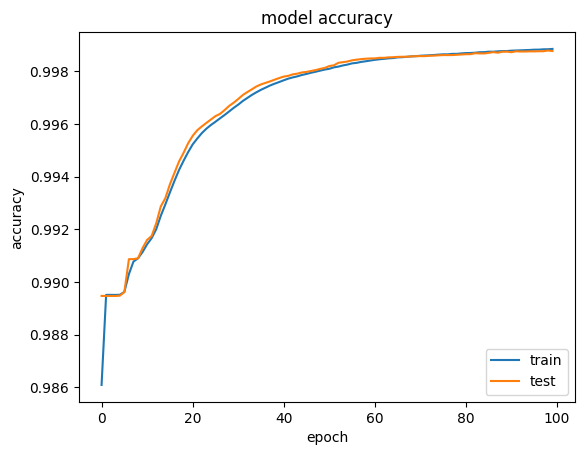

In [ ]:
#lstm_model
plt.plot(lstm_history.history['categorical_accuracy'])
plt.plot(lstm_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' , 'test'], loc= "lower right")
plt.show()

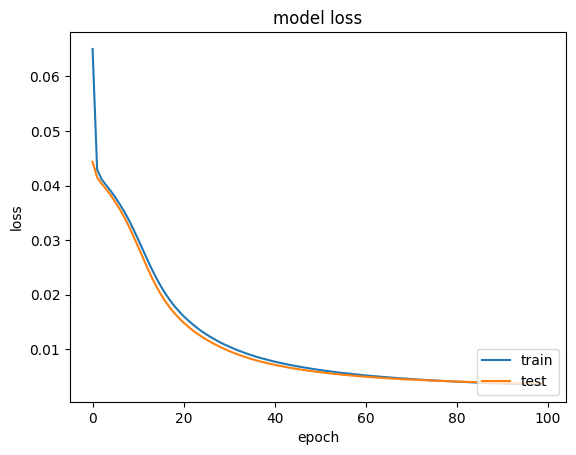

In [ ]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train' , 'test'], loc= "lower right")
plt.show()

**Performance_Evaluation**

In [ ]:
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print("LSTM_Model \nLoss: {0}, \nTestAccuracy: {1}".format(loss, accuracy))

1997/1997 [==============================] - 10s 5ms/step - loss: 0.0036 - categorical_accuracy: 0.9988
LSTM_Model 
Loss: 0.003614935325458646, 
TestAccuracy: 0.9987888932228088


**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

y_pred = lstm_model.predict(X_test)

y_pred2 = np.argmax(y_pred, axis=-1)

y_true = np.argmax(y_test, axis=-1)

tags = ['ADVe','AJe','CONJe','DETe','NUMe','Ne','PROe','Pe','RESe','Ve']

1997/1997 [==============================] - 7s 3ms/step


In [ ]:
set(y_pred2.flatten())

{0, 2, 4, 5, 6, 7, 8, 9}

In [ ]:
report = classification_report(y_true.flatten(), y_pred2.flatten(),target_names=tags)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        ADVe       1.00      1.00      1.00   7226318
         AJe       0.00      0.00      0.00       213
       CONJe       0.95      0.90      0.92      5576
        DETe       0.00      0.00      0.00       351
        NUMe       0.95      0.94      0.95     44393
          Ne       1.00      0.81      0.89       563
        PROe       0.96      0.91      0.94      4670
          Pe       0.91      0.91      0.91      2211
        RESe       0.90      0.94      0.92     21997
          Ve       0.99      0.99      0.99    361948

    accuracy                           1.00   7668240
   macro avg       0.77      0.74      0.75   7668240
weighted avg       1.00      1.00      1.00   7668240



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
